# EX10. 번역기를 만들어보자

In [1]:
import tensorflow
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import re

In [2]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 194513


,eng,fra,cc
58057,Our TV is out of order.,Notre téléviseur est en panne.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
69713,He tried to kill himself.,Il a tenté de se suicider.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
112562,Where are the other prisoners?,Où sont les autres prisonniers ?,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
180771,I have a friend whose father is a famous novel...,J'ai un ami dont le père est un romancier célè...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
160362,I'd like to have your answer right away.,Je voudrais votre réponse immédiatement.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [3]:
#세번째 열은 불필요하므로 제거하고, 훈련 데이터는 33000개의 샘플로 줄입니다.
lines = lines[['eng', 'fra']][:33000] 
lines.sample(5)

,eng,fra
27311,Who gave you this?,Qui vous a donné ça ?
10272,I did warn you.,Je vous avais prévenue.
20649,This feels right.,Ça semble correct.
6288,We're biased.,Notre point de vue est biaisé.
22231,You're satisfied.,Vous êtes contentes.


## Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!) 

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # re.sub(pattern, replace, text) text 중 pattern에 해당하는 부분을 replace로 대체한다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = sentence.split(" ")
    
    return sentence

## Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

In [5]:
def preprocess_sentence_decoder(sentence):
    sentence = sentence.lower().strip()
  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    sentence = sentence.split(" ")
    
    return sentence

In [6]:
lines.eng = lines.eng.apply(lambda x : preprocess_sentence(x))
lines.fra = lines.fra.apply(lambda x : preprocess_sentence_decoder(x))

In [7]:
lines.eng.sample(5)

21486      [we, re, not, eating, .]
15471        [she, trusted, you, .]
5536            [keep, it, warm, .]
28067    [are, you, having, fun, ?]
6876          [give, it, a, try, .]
Name: eng, dtype: object

In [8]:
lines.fra.sample(5)

31258       [<start>, elle, l, a, invit, entrer, ., <end>]
23182           [<start>, il, se, refusa, payer, ., <end>]
1861     [<start>, dirigez, vous, vers, le, sud, ., <end>]
23160               [<start>, il, habite, tokyo, ., <end>]
15036       [<start>, c, est, vraiment, marrant, ., <end>]
Name: fra, dtype: object

#### seq2seq의 인코더-디코더 구조

seq2seq는 두 개의 RNN 아키텍처를 연결한 구조입니다. 입력 문장을 받는 RNN을 인코더라고 하고, 두번째 RNN을 디코더라고 합니다.
seq2seq의 feature vector는 인코더 RNN이 입력문장을 해석해서 만들어 낸 hidden state 벡터입니다. 즉, A언어의 문장 X를 z라는 hidden state로 해석한 후 z를 다시 B 언어의 문장 Y로 재생성하는 것입니다. 

디코더는 인코더의 마지막 time step의 hidden state를 전달 받아 자신의 초기 hidden state로 하고, 출력 문장을 생성해내기 시작합니다. 여기서는 특수 문자를 사용해서 출력 문장의 시작과 종료를 알려주어야 하는데, SOS와 EOS를 사용합니다. SOS는 start of sequence를 의미하며, EOS는 end of sequence를 의미합니다.

이제 단어장(vocabulary)을 만들고, 각 단어에 부여된 고유한 정수로 텍스트 시퀀스를 정수 시퀀스로 변환하는 정수 인코딩 과정을 거치겠습니다. 이때 영어와 프랑스어는 사용하는 언어가 다르므로 단어장을 별도로 만들어줍니다. 그리고 정상적으로 정수 시퀀스로 변환되었는지 3개의 행을 출력합니다.

## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [9]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(lines.eng)

In [10]:
print(eng_tokenizer.word_index)

{'.': 1, 'i': 2, 'you': 3, '?': 4, 'tom': 5, 'it': 6, 'is': 7, 's': 8, 'a': 9, 're': 10, 'we': 11, 'm': 12, 't': 13, 'the': 14, 'that': 15, 'he': 16, 'was': 17, 'me': 18, 'this': 19, 'they': 20, 'to': 21, 'are': 22, '!': 23, 'do': 24, 'can': 25, 'my': 26, 'your': 27, 'have': 28, 'go': 29, 'not': 30, 'don': 31, 'll': 32, 'be': 33, 'she': 34, 'no': 35, 'what': 36, 'did': 37, 'all': 38, 'here': 39, 'let': 40, 'like': 41, 'in': 42, 'get': 43, 'up': 44, 'very': 45, 'how': 46, 'on': 47, 'need': 48, 'one': 49, 'want': 50, 'him': 51, 'out': 52, 'love': 53, 'who': 54, 'come': 55, 'there': 56, 'just': 57, 'please': 58, 'now': 59, 'us': 60, 'know': 61, 'stop': 62, 'so': 63, 'of': 64, 'got': 65, 'too': 66, 'help': 67, 'look': 68, 'take': 69, 'were': 70, 'good': 71, 'for': 72, 'has': 73, 've': 74, 'see': 75, 'at': 76, 'will': 77, 'keep': 78, 'am': 79, 'had': 80, 'back': 81, 'give': 82, 'feel': 83, 'try': 84, 'stay': 85, 'saw': 86, 'must': 87, 'happy': 88, 'home': 89, 'where': 90, 'alone': 91, 'didn

In [11]:
input_text = eng_tokenizer.texts_to_sequences(lines.eng)
input_text[:10]

[[29, 1],
 [29, 1],
 [29, 1],
 [764, 1],
 [764, 1],
 [200, 23],
 [200, 23],
 [200, 23],
 [200, 23],
 [200, 23]]

In [12]:
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(lines.fra)
print(fra_tokenizer.word_index)
target_text = fra_tokenizer.texts_to_sequences(lines.fra)

{'<start>': 1, '<end>': 2, '.': 3, 'je': 4, 'est': 5, '?': 6, 'tom': 7, '!': 8, 'vous': 9, 'a': 10, 'j': 11, 'pas': 12, 'il': 13, 'nous': 14, 'le': 15, 'ai': 16, 'de': 17, 'l': 18, 'c': 19, 'ne': 20, 'suis': 21, 'tu': 22, 'd': 23, 's': 24, 't': 25, 'un': 26, 'la': 27, 'en': 28, 'n': 29, 'ce': 30, 'me': 31, 'tes': 32, 'es': 33, 'une': 34, 'que': 35, 'les': 36, 'e': 37, 'm': 38, 'moi': 39, 'te': 40, 'elle': 41, 'sommes': 42, 'y': 43, 'tait': 44, 'sont': 45, 'ils': 46, 'fait': 47, 'r': 48, 'tout': 49, 'elles': 50, 'qui': 51, 'des': 52, 'aime': 53, 'mon': 54, 're': 55, 'toi': 56, 'bien': 57, 'as': 58, 'ici': 59, 'tr': 60, 'avons': 61, 'pr': 62, 'se': 63, 'du': 64, 'on': 65, 'faire': 66, 'besoin': 67, 'arr': 68, 'air': 69, 'avez': 70, 'peux': 71, 'qu': 72, 'cela': 73, 'ont': 74, 'va': 75, 'personne': 76, 'veux': 77, 'votre': 78, 'tais': 79, 'fais': 80, 'tre': 81, 'tous': 82, 'ma': 83, 'faut': 84, 'ton': 85, 'aller': 86, 'comment': 87, 'trop': 88, 'monde': 89, 'adore': 90, 'au': 91, 'mainten

In [13]:
target_text[:10]

[[1, 75, 8, 2],
 [1, 378, 3, 2],
 [1, 718, 8, 2],
 [1, 747, 8, 2],
 [1, 747, 3, 2],
 [1, 677, 8, 2],
 [1, 1882, 8, 2],
 [1, 182, 266, 1033, 266, 2627, 8, 2],
 [1, 1329, 8, 2],
 [1, 2181, 8, 2]]

In [14]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4671
프랑스어 단어장의 크기 : 7460


In [15]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [16]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4671
프랑스어 단어장의 크기 : 7460
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [17]:
sos_token = '<start>'
eos_token = '<end>'

encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [18]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


In [19]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [20]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(30000, 8)
(30000, 17)
(30000, 17)
(3000, 8)
(3000, 17)
(3000, 17)


## Step 4. 임베딩 층(Embedding layer) 사용하기 

In [21]:
encoder_inputs = Input(shape=(None,))
# encoder embedding
enc_emb = Embedding(eng_vocab_size, 256, input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(units = 256, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

In [22]:
decoder_inputs = Input(shape=(None,))
# decoder embedding
dec_emb = Embedding(fra_vocab_size, 256)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

## Step 5. 모델 구현하기

In [23]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1195776     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    1909760     input_2[0][0]                    
______________________________________________________________________________________________

Epoch 1/20
469/469 [==============================] - 18s 21ms/step - loss: 1.9018 - val_loss: 1.5071
Epoch 2/20
469/469 [==============================] - 8s 16ms/step - loss: 1.3560 - val_loss: 1.2473
Epoch 3/20
469/469 [==============================] - 8s 16ms/step - loss: 1.1048 - val_loss: 1.0685
Epoch 4/20
469/469 [==============================] - 8s 16ms/step - loss: 0.9400 - val_loss: 0.9505
Epoch 5/20
469/469 [==============================] - 8s 16ms/step - loss: 0.8111 - val_loss: 0.8648
Epoch 6/20
469/469 [==============================] - 8s 16ms/step - loss: 0.7047 - val_loss: 0.8034
Epoch 7/20
469/469 [==============================] - 8s 16ms/step - loss: 0.6141 - val_loss: 0.7503
Epoch 8/20
469/469 [==============================] - 8s 16ms/step - loss: 0.5350 - val_loss: 0.7120
Epoch 9/20
469/469 [==============================] - 8s 17ms/step - loss: 0.4647 - val_loss: 0.6786
Epoch 10/20
469/469 [==============================] - 8s 16ms/step - loss: 0.4042 - val_l

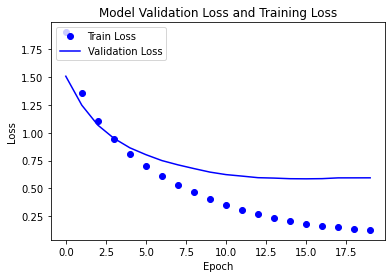

In [24]:
history = model.fit([encoder_input_train, decoder_input_train],decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 64, epochs = 20)

#  훈련 과정 시각화 (정확도)
plt.plot(history.history['loss'], 'bo')
plt.plot(history.history['val_loss'], 'b')
plt.title('Model Validation Loss and Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss ', 'Validation Loss'], loc='upper left')
plt.show()

In [25]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         1195776   
_________________________________________________________________
masking (Masking)            (None, None, 256)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 1,721,088
Trainable params: 1,721,088
Non-trainable params: 0
_________________________________________________________________


In [26]:
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, 256)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [27]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    1909760     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [28]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [29]:
eng2idx
eng_tokenizer.word_index

{'.': 1,
 'i': 2,
 'you': 3,
 '?': 4,
 'tom': 5,
 'it': 6,
 'is': 7,
 's': 8,
 'a': 9,
 're': 10,
 'we': 11,
 'm': 12,
 't': 13,
 'the': 14,
 'that': 15,
 'he': 16,
 'was': 17,
 'me': 18,
 'this': 19,
 'they': 20,
 'to': 21,
 'are': 22,
 '!': 23,
 'do': 24,
 'can': 25,
 'my': 26,
 'your': 27,
 'have': 28,
 'go': 29,
 'not': 30,
 'don': 31,
 'll': 32,
 'be': 33,
 'she': 34,
 'no': 35,
 'what': 36,
 'did': 37,
 'all': 38,
 'here': 39,
 'let': 40,
 'like': 41,
 'in': 42,
 'get': 43,
 'up': 44,
 'very': 45,
 'how': 46,
 'on': 47,
 'need': 48,
 'one': 49,
 'want': 50,
 'him': 51,
 'out': 52,
 'love': 53,
 'who': 54,
 'come': 55,
 'there': 56,
 'just': 57,
 'please': 58,
 'now': 59,
 'us': 60,
 'know': 61,
 'stop': 62,
 'so': 63,
 'of': 64,
 'got': 65,
 'too': 66,
 'help': 67,
 'look': 68,
 'take': 69,
 'were': 70,
 'good': 71,
 'for': 72,
 'has': 73,
 've': 74,
 'see': 75,
 'at': 76,
 'will': 77,
 'keep': 78,
 'am': 79,
 'had': 80,
 'back': 81,
 'give': 82,
 'feel': 83,
 'try': 84,
 'stay':

In [30]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [31]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [32]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

Step 6. 모델 평가하기

In [33]:
pip install googletrans==4.0.0-rc1

Note: you may need to restart the kernel to use updated packages.


In [34]:
from googletrans import Translator
translator = Translator()

In [37]:
for seq_index in [(np.random.randint(1, 1500)), (np.random.randint(1, 1500)),
                  (np.random.randint(1, 1500)), (np.random.randint(1, 1500)),
                  (np.random.randint(1, 1500)),(np.random.randint(1, 1500))]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(40 * "-")
    
    input_sentence = seq2src(encoder_input_test[seq_index])
    print('입력 문장:', input_sentence)
    target_sentence = decoder_input_test[seq_index]
    print('정답 문장:', seq2tar(target_sentence))
    output_sentence = decoded_sentence[:len(decoded_sentence)-1]
    print('번역기가 번역한 문장:', output_sentence)
    
    print("영어 입력문장을 한글로: ", translator.translate(input_sentence, src = 'en', dest='ko').text)
    print("번역한 프랑스어 문장을 한글로: ", translator.translate(output_sentence, src = 'fr', dest='ko').text)

----------------------------------------
입력 문장: tom fought well . 
정답 문장: tom s est bien battu . 
번역기가 번역한 문장:  tom s bien . . . 
영어 입력문장을 한글로:  톰은 잘 싸웠다.
번역한 프랑스어 문장을 한글로:  톰 잘...
----------------------------------------
입력 문장: they re all dead . 
정답 문장: ils sont tous d c d s . 
번역기가 번역한 문장:  ils sont tous . 
영어 입력문장을 한글로:  그들은 모두 죽었다.
번역한 프랑스어 문장을 한글로:  그들은 모두입니다.
----------------------------------------
입력 문장: that will help . 
정답 문장: a aidera . 
번역기가 번역한 문장:  a a . . . . . . 
영어 입력문장을 한글로:  도움이 될 것입니다.
번역한 프랑스어 문장을 한글로:  A a......
----------------------------------------
입력 문장: were you hurt ? 
정답 문장: avez vous t bless e ? 
번역기가 번역한 문장:  avez t t ? ? ? ? 
영어 입력문장을 한글로:  당신은 다쳤습니까?
번역한 프랑스어 문장을 한글로:  t가 있습니까????
----------------------------------------
입력 문장: tom is shaving . 
정답 문장: tom se rase . 
번역기가 번역한 문장:  tom tom tom . . 
영어 입력문장을 한글로:  톰은 면도하고 있습니다.
번역한 프랑스어 문장을 한글로:  톰 톰 톰..
----------------------------------------
입력 문장: it failed . 
정답 문장: a a chou . 
번역기가 번역한 문장:  quelqu

회고

- 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다. 구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다. 

- seq2seq 기반의 번역기 모델이 정상적으로 구동된다. seq2seq 모델 훈련 결과를 그래프로 출력해보았고, validation loss그래프가 우하향하는 성향을 보였다.

- 테스트 결과 느낌만 비슷한 문장을 만드는 수준이었고 의미가 통하는 문장은 만들지 못했다. 

- 테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 문장 중 한 두 단어가 같은 수준이거나 아예 안맞을 때도 있었다. 